In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import requests

In [21]:
# Define API URL
url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&outputsize=full&apikey=demo"

# Make API Request
r = requests.get(url)
data = r.json()

# Extract the time series data
time_series = data["Time Series (5min)"]  # Adjust key based on interval

# Convert to DataFrame
df = pd.DataFrame.from_dict(time_series, orient="index")
df.columns = ["open", "high", "low", "close", "volume"]

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Sort by time (oldest to newest)
df = df.sort_index()

# Convert numeric values
df = df.astype(float)

# Display DataFrame
print(df.head())

                       open    high     low   close  volume
2025-02-18 04:00:00  260.00  261.27  260.00  260.45   953.0
2025-02-18 04:05:00  260.47  260.93  260.47  260.79    42.0
2025-02-18 04:10:00  260.79  260.96  260.52  260.57   170.0
2025-02-18 04:15:00  260.57  260.90  260.36  260.90   148.0
2025-02-18 04:20:00  260.68  260.68  260.68  260.68     2.0


In [22]:
df

,open,high,low,close,volume
2025-02-18 04:00:00,260.00,261.27,260.00,260.45,953.0
2025-02-18 04:05:00,260.47,260.93,260.47,260.79,42.0
2025-02-18 04:10:00,260.79,260.96,260.52,260.57,170.0
2025-02-18 04:15:00,260.57,260.90,260.36,260.90,148.0
2025-02-18 04:20:00,260.68,260.68,260.68,260.68,2.0
...,...,...,...,...,...
2025-03-17 19:30:00,253.25,253.50,253.25,253.25,8.0
2025-03-17 19:35:00,253.50,253.50,253.25,253.25,11.0
2025-03-17 19:40:00,253.25,253.25,253.25,253.25,9.0
2025-03-17 19:45:00,253.00,253.00,253.00,253.00,1.0


In [25]:
# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Create Sequences for LSTM to Predict All Columns for Next Day Hourly Prices
def create_sequences(data, seq_length, prediction_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - prediction_horizon):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+prediction_horizon])  # Predicting all columns
    return np.array(X), np.array(y)

SEQ_LENGTH = 50
PREDICTION_HORIZON = 8  # Predicting next day's hourly prices (9 AM to 4 PM)
X, y = create_sequences(df_scaled, SEQ_LENGTH, PREDICTION_HORIZON)

# Split Data into Train & Test Sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, df.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(PREDICTION_HORIZON * df.shape[1])  # Output predictions for all columns
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model.fit(X_train, y_train.reshape(y_train.shape[0], -1), epochs=20, batch_size=32, validation_data=(X_test, y_test.reshape(y_test.shape[0], -1)))

# Predict Next Day's Hourly Data
last_50_days = df_scaled[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, df.shape[1])
next_day_prediction = model.predict(last_50_days).reshape(PREDICTION_HORIZON, df.shape[1])
next_day_prices = scaler.inverse_transform(next_day_prediction)

# Print Predictions for Each Hour (9 AM - 4 PM)
hours = ["9 AM", "10 AM", "11 AM", "12 PM", "1 PM", "2 PM", "3 PM", "4 PM"]
predictions_df = pd.DataFrame(next_day_prices, columns=df.columns, index=hours)
print("Predicted Next Day's Hourly Data:")
print(predictions_df)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.2816 - val_loss: 0.0150
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0176 - val_loss: 0.0145
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0101 - val_loss: 0.0063
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.0073 - val_loss: 0.0033
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 9/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 10/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 11/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 12/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0028 - val_l

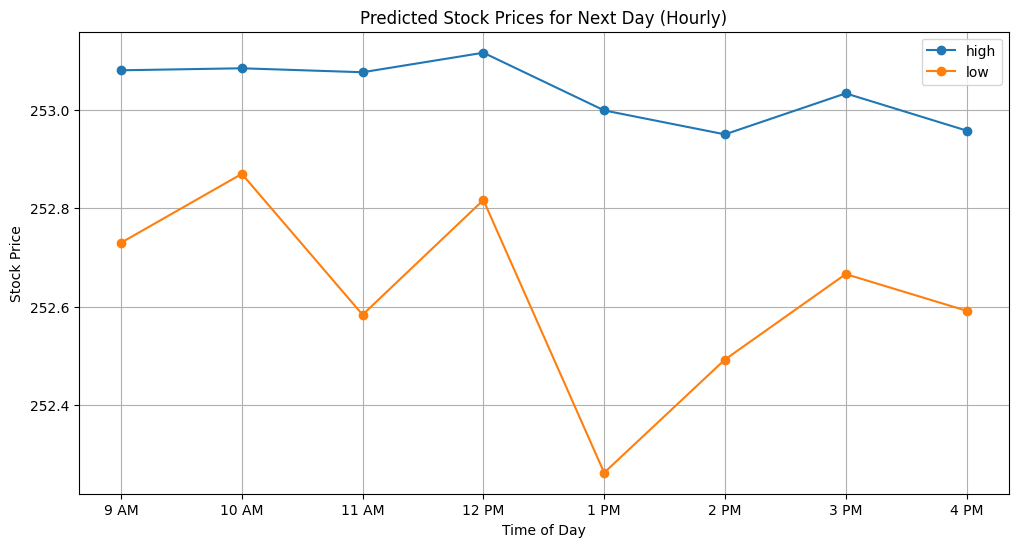

In [30]:
# Visualization for Stock Prices (High, Low)
plt.figure(figsize=(12, 6))
for column in ['high', 'low']:
    plt.plot(hours, predictions_df[column], marker='o', label=column)
plt.xlabel("Time of Day")
plt.ylabel("Stock Price")
plt.title("Predicted Stock Prices for Next Day (Hourly)")
plt.legend()
plt.grid()
plt.show()

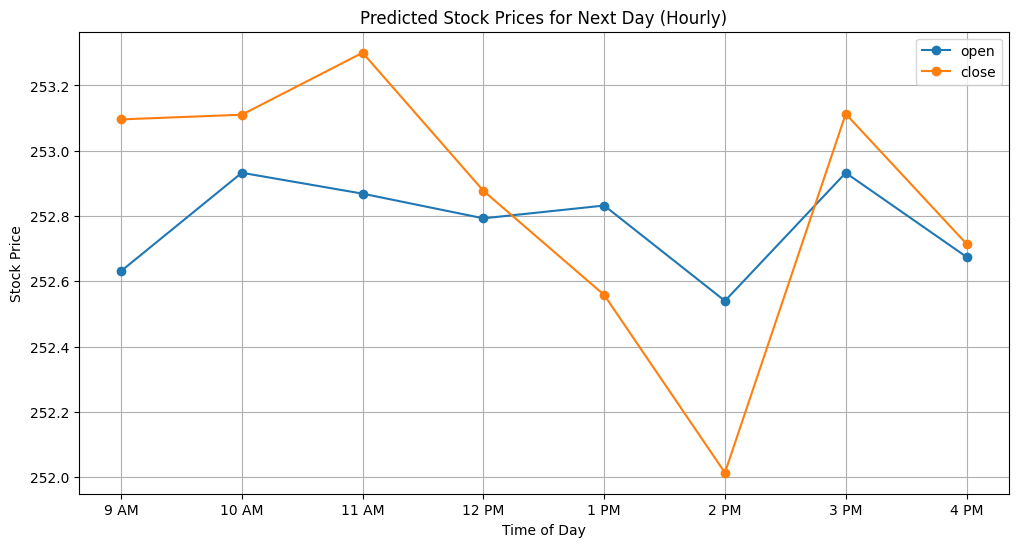

In [31]:
# Visualization for Stock Prices (Close, Open)
plt.figure(figsize=(12, 6))
for column in ['open', 'close']:
    plt.plot(hours, predictions_df[column], marker='o', label=column)
plt.xlabel("Time of Day")
plt.ylabel("Stock Price")
plt.title("Predicted Stock Prices for Next Day (Hourly)")
plt.legend()
plt.grid()
plt.show()